In [18]:
import pandas as pd
from scipy.signal import butter, lfilter, freqz
import numpy as np
import matplotlib.pyplot as plt
import json
import heartpy as hp
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from hrvanalysis import get_time_domain_features, get_frequency_domain_features
from hrvanalysis import plot_poincare
import os.path

##### notes 
Algorithms documentation
https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/algorithmfunctioning.html

API documentation
https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/apiref.html

Overview on HR features
https://www.frontiersin.org/articles/10.3389/fpubh.2017.00258/full

### Setting up a few wrapper functions

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def ecg_preprocess(ecg_sig, fs, cutoff=3., filter_order=1):
    # to be reviewed in detail, order might not be optimal
    ecg_sig = butter_lowpass_filter(ecg_sig, cutoff, fs=fs, order=filter_order)
    ecg_sig = hp.remove_baseline_wander(ecg_sig, fs)
    ecg_sig = hp.enhance_ecg_peaks(ecg_sig, fs, iterations = 1)
    return ecg_sig

def hrv_preprocess(rr_intervals_list):

    rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list,  
                                                    low_rri=300, high_rri=2000)
    outliers_rej_rate = 1.-(len(rr_intervals_without_outliers)/len(rr_intervals_list))
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
                                                    interpolation_method="linear")
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

    return interpolated_nn_intervals, outliers_rej_rate

def hrv_time_domain_features(nn_intervals_list):
    return get_time_domain_features(nn_intervals_list)

def hrv_freq_domain_features(nn_intervals_list):
    return get_frequency_domain_features(nn_intervals_list)


def make_data_path(base_path, sbj_id, ses_id, run_id, task='AP', mod='ppg'):
    data_filename = "{0}_ses-{1}_task-rest_acq-{2}_run-{3}_recording-{4}_physio.tsv".format(sbj_id, ses_id, task, run_id, mod)
    data_path = base_path+"{0}/ses-{1}/func/{2}".format(sbj_id, ses_id, data_filename)

    return data_path


def make_metadata_path(base_path, sbj_id, ses_id, run_id, task='AP', mod='ppg'):
    metadata_filename = "{0}_ses-{1}_task-rest_acq-{2}_run-{3}_recording-{4}_physio.json".format(sbj_id, ses_id, task, run_id, mod)
    metadata_path = base_path+"{0}/ses-{1}/func/{2}".format(sbj_id, ses_id, metadata_filename)

    return metadata_path



### checking for availability of different modalities in the dataset

In [8]:
availability_path = "../data/raw/LEMON/Behavioural_Data_MPILMBB_LEMON/Data_Availability_Tables/Availability_LEMON_Day1_Data.csv"
availability_df = pd.read_csv(availability_path)
availability_df = availability_df.rename(columns={'Unnamed: 0':'sbj_id'})
availability_df = availability_df.dropna()

measure = 'Pulse_Photoplethysmography'
mask = availability_df[measure] == True
sbj_list = availability_df[mask]['sbj_id'].values

### creating a table of paths where to find the physio files for each subject

In [9]:
base_path = '../data/raw/LEMON/physio/'
sbj_data_df = {'sbj_id':[], 'ses_id':[], 'run_id':[], 'task':[], 'data_path':[], 'metadata_path':[]}

for sbj_id in sbj_list[:]:
    for ses_id in ['01', '02']:
        for run_id in ['01', '02', '03']:
            for task in ['AP', 'PA']:
                metadata_path = make_metadata_path(base_path, sbj_id, ses_id, run_id, task)
                data_path = make_data_path(base_path, sbj_id, ses_id, run_id, task)
                if os.path.isfile(metadata_path) and os.path.isfile(data_path):
                    sbj_data_df['sbj_id'].append(sbj_id)
                    sbj_data_df['ses_id'].append(ses_id)
                    sbj_data_df['run_id'].append(run_id)
                    sbj_data_df['task'].append(task)
                    sbj_data_df['data_path'].append(data_path)
                    sbj_data_df['metadata_path'].append(metadata_path)

sbj_data_df = pd.DataFrame.from_dict(sbj_data_df)


In [10]:
sbj_data_df

,sbj_id,ses_id,run_id,task,data_path,metadata_path
0,sub-032304,01,01,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
1,sub-032304,02,01,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
2,sub-032304,02,01,PA,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
3,sub-032304,02,02,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
4,sub-032304,02,02,PA,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
...,...,...,...,...,...,...
276,sub-032520,01,01,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
277,sub-032521,01,01,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
278,sub-032522,01,01,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...
279,sub-032523,01,01,AP,/Users/giovanni/Documents/Datasets/LEMON/physi...,/Users/giovanni/Documents/Datasets/LEMON/physi...


### inspecting signal for one subject


sub-032304


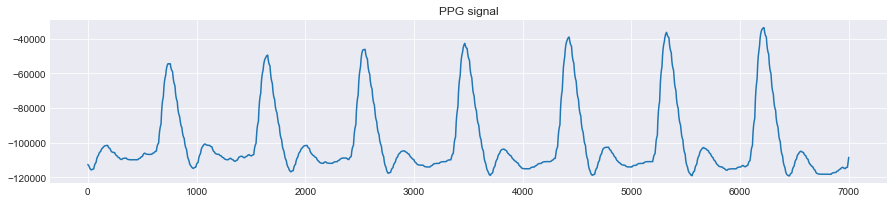

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.


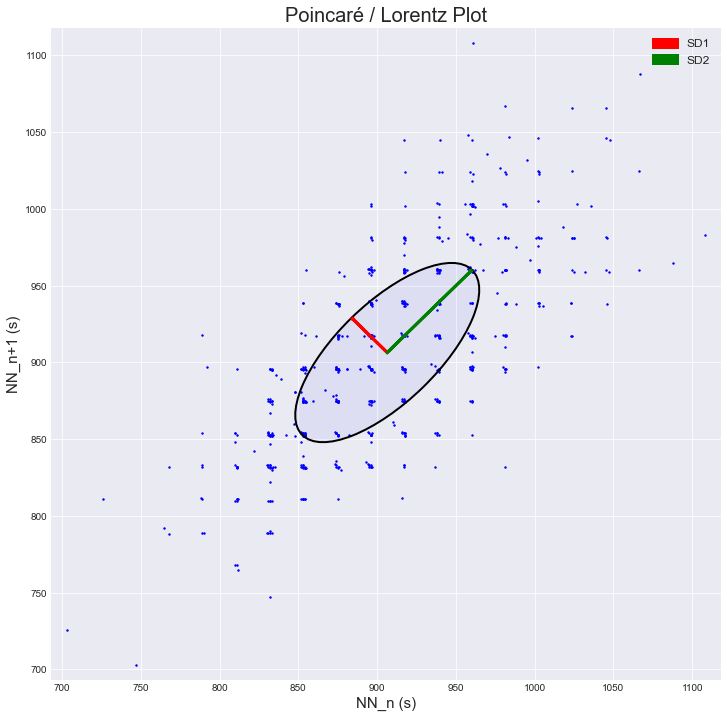

In [22]:
sbj_r = sbj_data_df.iloc[0]

sbj_id = sbj_r['sbj_id']
run_id = sbj_r['run_id']
ses_id = sbj_r['ses_id']
task = sbj_r['task']
data_path = sbj_r['data_path']
metadata_path = sbj_r['metadata_path']

print(sbj_id)

metadata = json.loads(open(metadata_path).read())
fs = metadata['SamplingFrequency']
sig_df = pd.read_csv(data_path.format(data_path), sep='\t', names=metadata['Columns']+["none"])
sig = sig_df[sig_df.columns[0]].values

plt.figure(figsize=(15,3))
plt.plot(sig[:7000])
plt.title('PPG signal')
plt.show()


metadata = json.loads(open(metadata_path).read())
fs = metadata['SamplingFrequency']
sig_df = pd.read_csv(data_path.format(data_path), sep='\t', names=metadata['Columns']+["none"])
sig = sig_df[sig_df.columns[0]].values

working_data, hr_features = hp.process(sig, fs)

    
hr_features['sdnn_hr'] = hr_features.pop('sdnn')
hr_features['sdsd_hr'] = hr_features.pop('sdsd')
hr_features['rmssd_hr'] = hr_features.pop('rmssd')

rr_intervals_list = working_data['RR_list']
rr_intervals_list = working_data['RR_list']
interpolated_nn_intervals, hrv_rej_rate = hrv_preprocess(rr_intervals_list)
plot_poincare(interpolated_nn_intervals, plot_sd_features=True)



### extracting features for all subjects

NOTE: We reject subjects with a peak rejection rate > 10%

In [145]:
for sbj_n, sbj_r in sbj_data_df.iterrows():

    sbj_id = sbj_r['sbj_id']
    run_id = sbj_r['run_id']
    ses_id = sbj_r['ses_id']
    task = sbj_r['task']
    data_path = sbj_r['data_path']
    metadata_path = sbj_r['metadata_path']

    print(sbj_id)

    metadata = json.loads(open(metadata_path).read())
    fs = metadata['SamplingFrequency']
    sig_df = pd.read_csv(data_path.format(data_path), sep='\t', names=metadata['Columns']+["none"])
    sig = sig_df[sig_df.columns[0]].values

    try:
        working_data, hr_features = hp.process(sig, fs)
    except:
        print('skipping {0}. Bad signal?'.format(data_path))
        continue
    
    hr_features['sdnn_hr'] = hr_features.pop('sdnn')
    hr_features['sdsd_hr'] = hr_features.pop('sdsd')
    hr_features['rmssd_hr'] = hr_features.pop('rmssd')

    rejection_rate = len(working_data['removed_beats'])/len(working_data['peaklist'])
    if rejection_rate > 0.1:
        continue

    # HRV preprocessing
    rr_intervals_list = working_data['RR_list']
    interpolated_nn_intervals, hrv_rej_rate = hrv_preprocess(rr_intervals_list)

    # HRV time domain features
    time_domain_features = hrv_time_domain_features(interpolated_nn_intervals)

    # HRV freq domain features
    freq_domain_features = hrv_freq_domain_features(interpolated_nn_intervals)

    if sbj_n == 0:
        feature_names = ['sbj_id', 'ses_id', 'run_id', 'task', 'peak_rej_rate', 'hrv_rej_rate']
        feature_names += list(hr_features.keys())
        feature_names += list(time_domain_features.keys())
        feature_names += list(freq_domain_features.keys())

        hrv_df = {k:[] for k in feature_names}

    hrv_df['sbj_id'].append(sbj_id)
    hrv_df['ses_id'].append(ses_id)
    hrv_df['run_id'].append(run_id)
    hrv_df['task'].append(task)
    hrv_df['peak_rej_rate'].append(rejection_rate)
    hrv_df['hrv_rej_rate'].append(hrv_rej_rate)

    for k,v in hr_features.items():
        hrv_df[k].append(v)

    for k,v in time_domain_features.items():
        hrv_df[k].append(v)

    for k,v in freq_domain_features.items():
        hrv_df[k].append(v)






sub-032304
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
sub-032304
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [145.0]
2 ectopic beat(s) have been deleted with malik rule.
sub-032304
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
sub-032304
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [278.0]
4 ectopic beat(s) have been deleted with malik rule.
sub-032304
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
sub-032328
0 outlier(s) have been deleted.
5 ectopic beat(s) have been deleted with malik rule.
sub-032328
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
sub-032330
0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.
sub-032330
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [66.0]
2 ectopic beat(s) have been deleted with malik rule.
sub-032330
0 outlier(s)

/Users/giovanni/opt/anaconda3/envs/biomkr_397/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


2 outlier(s) have been deleted.
The outlier(s) value(s) are : [214.0, 97.0]
2 ectopic beat(s) have been deleted with malik rule.
sub-032353
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [86.0, 77.0, 89.0, 116.0]
0 ectopic beat(s) have been deleted with malik rule.
sub-032354
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
sub-032356
3 outlier(s) have been deleted.
The outlier(s) value(s) are : [71.0, 67.0, 2001.9999999999998]
5 ectopic beat(s) have been deleted with malik rule.
sub-032356
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [180.0]
2 ectopic beat(s) have been deleted with malik rule.
sub-032356
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [105.0]
0 ectopic beat(s) have been deleted with malik rule.
sub-032356
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
sub-032356
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
sub-

### saving data to table

In [140]:
hrv_df = pd.DataFrame(hrv_df)

processed_path = '../data/processed/'
hrv_df.to_json(processed_path+'LEMON_ppg_features.json')
